In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
workspaceFolder = "/home/gabor/Projects/bnn_seq_vi"
seq_args = [
    "--seed=3",
    # "--weight_decay=15",
    # f"--pretrained_prior_checkpoint={workspaceFolder}/bnn_hmc/.runs/vi/regtest2/mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.001___epochs_300_wd_0.5_batchsize_1_temp_1.0__seed_11/model_step_299.pt",
    f"--dir={workspaceFolder}/bnn_hmc/.runs/sgd/visualize/",
    "--dataset_name=regtest_1",
    "--model_name=bayesian_regression",
    # "--init_step_size=1e-4",
    # "--num_epochs=500",
    # "--eval_freq=50",
    # "--batch_size=1",
    # "--save_freq=500",
    # "--vi_sigma_init=1e-3",
]

In [3]:
import os
import pandas as pd
import importlib
os.chdir("../..")

In [6]:
from jax import numpy as jnp
import jax
import pandas as pd
import tensorflow.compat.v2 as tf
import argparse

from bnn_hmc.utils import checkpoint_utils
from bnn_hmc.utils import cmd_args_utils
from bnn_hmc.utils import logging_utils
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import optim_utils
from bnn_hmc.utils import script_utils
from bnn_hmc.core import vi

parser = argparse.ArgumentParser(description="Run SGD on a cloud TPU")
cmd_args_utils.add_common_flags(parser)
cmd_args_utils.add_sgd_flags(parser)
parser.add_argument("--vi_sigma_init", default=1e-3)

args = parser.parse_args(seq_args)
train_utils.set_up_jax(args.tpu_ip, args.use_float64)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
(train_set, test_set, net_apply, params, net_state, key, log_likelihood_fn,
   log_prior_fn, _, predict_fn, ensemble_upd_fn, metrics_fns,
   tabulate_metrics) = script_utils.get_data_model_fns(args)

In [9]:
VI_POSTERIOR_CHECKPOINT = f"{workspaceFolder}/bnn_hmc/.runs/vi/regtest2/"\
                          "mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.001___epochs_300_wd_0.5_batchsize_1_temp_1.0__seed_11/"\
                          "model_step_299.pt"
VI_ENSEMBLE_PREDICT_SIZE = 500

In [10]:
posterior_params = checkpoint_utils.load_checkpoint(VI_POSTERIOR_CHECKPOINT)['params']
posterior_params

{'inv_softplus_std': {'linear': {'b': Array([-4.449687 , -4.4497023], dtype=float32),
   'w': Array([[-4.4497523, -4.4496865]], dtype=float32)}},
 'mean': {'linear': {'b': Array([ 0.29441336, -0.16342908], dtype=float32),
   'w': Array([[-0.29441342,  0.16342911]], dtype=float32)}}}

In [11]:
  # Convert the model to MFVI parameterization
net_apply, mean_apply, _, _posterior_params, net_state = vi.get_mfvi_model_fn(
    net_apply, posterior_params, net_state, seed=0, sigma_init=args.vi_sigma_init)
# prior_kl = vi.make_kl_with_gaussian_prior(args.weight_decay, args.temperature)
num_devices = len(jax.devices())
net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))

In [12]:
def vi_ensemble_predict_fn(net_apply, params, net_state, ds):
    net_state, all_preds = jax.lax.scan(
        lambda state, _: predict_fn(net_apply, params, state, ds),
        init=net_state,
        xs=jnp.arange(VI_ENSEMBLE_PREDICT_SIZE))

    ensemble_predictions = None
    num_ensembled = 0
    for pred in all_preds:
        ensemble_predictions = ensemble_upd_fn(ensemble_predictions,
                                                num_ensembled, pred)
        num_ensembled += 1
    return net_state, ensemble_predictions, all_preds

In [24]:
net_state, test_predictions, all_preds = vi_ensemble_predict_fn(net_apply, posterior_params, net_state, test_set)
posterior_mean = test_predictions[0, ..., 0]
posterior_mean_std = pd.DataFrame(all_preds[...,0,:,0]).std(axis=0)
predictive_std = test_predictions[0, ..., 1]

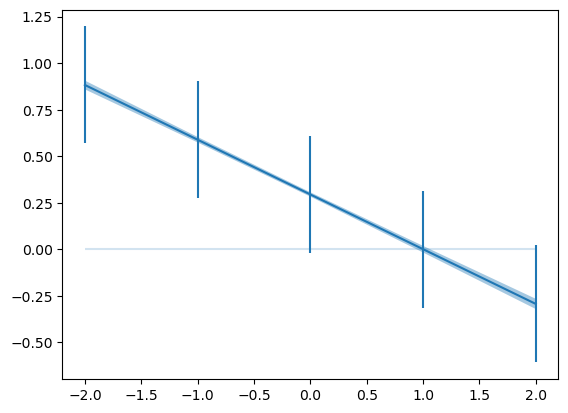

In [26]:
test_x = test_set[0][0, ..., 0]
plt.errorbar(test_x, posterior_mean, yerr=predictive_std)
plt.fill_between(test_x, posterior_mean-posterior_mean_std, posterior_mean+posterior_mean_std, alpha=0.4)
plt.hlines(y=0, xmin=-2, xmax=2, alpha=0.2)
plt.show()